In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from skimage.color import rgb2gray
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [10]:
# Step 1: Prepare dataset (noisy images + clean images)

import os
from sklearn.model_selection import train_test_split

# Path to the folder containing the images
folder_path = 'SIDD_image_files_full_resolution'

# Create lists to store ground truth and noisy images
ground_image_list = []
noisy_image_list = []

# List all files in the folder
file_list = os.listdir(folder_path)

# Iterate over the files and separate them based on "GT" and "NOISY" in the filename
for file_name in file_list:
    if "GT" in file_name:
        ground_image_list.append(file_name)
    elif "NOISY" in file_name:
        noisy_image_list.append(file_name)

# Split the ground truth and noisy image lists into training and testing sets
# Here, we use a 80-20 split, you can adjust the `test_size` parameter as needed
ground_train, ground_test = train_test_split(ground_image_list, test_size=0.2, random_state=42)
noisy_train, noisy_test = train_test_split(noisy_image_list, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets to verify the results
print("Ground Truth Training Images:", len(ground_train))
print("Ground Truth Testing Images:", len(ground_test))

print("Noisy Training Images:", len(noisy_train))
print("Noisy Testing Images:", len(noisy_test))


Ground Truth Training Images: 17
Ground Truth Testing Images: 5
Noisy Training Images: 17
Noisy Testing Images: 5


In [13]:
# Step 2: Load and preprocess the dataset

def preprocess_image(image_path):
    full_path = os.path.join(folder_path, image_path)
    image = Image.open(full_path)
    image = image.crop((0, 0, 512, 512))
    image = np.array(image) / 255.0
    return image

ground_images_train = np.array([preprocess_image(image_path) for image_path in ground_train])
noisy_images_train = np.array([preprocess_image(image_path) for image_path in noisy_train])

ground_images_test = np.array([preprocess_image(image_path) for image_path in ground_test])
noisy_images_test = np.array([preprocess_image(image_path) for image_path in noisy_test])

In [14]:
# Step 3: Build the CNN model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(512, 512, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

In [19]:
# Step 4: Compile and train the model

model.compile(optimizer='rmsprop', loss='mse')
model.fit(noisy_images_train, ground_images_train, batch_size=10, epochs=10)

Epoch 1/10
2/2 [==============================] - 48s 18s/step - loss: 0.0432
Epoch 2/10
2/2 [==============================] - 39s 16s/step - loss: 0.0435
Epoch 3/10
2/2 [==============================] - 37s 16s/step - loss: 0.0263
Epoch 4/10
2/2 [==============================] - 38s 16s/step - loss: 0.0130
Epoch 5/10
2/2 [==============================] - 37s 15s/step - loss: 0.0113
Epoch 6/10
2/2 [==============================] - 38s 16s/step - loss: 0.0125
Epoch 7/10
2/2 [==============================] - 38s 16s/step - loss: 0.0091
Epoch 8/10
2/2 [==============================] - 35s 13s/step - loss: 0.0068
Epoch 9/10
2/2 [==============================] - 24s 11s/step - loss: 0.0080
Epoch 10/10
2/2 [==============================] - 28s 12s/step - loss: 0.0068


In [20]:
# Step 5: Evaluate the model on the training set

train_loss = model.evaluate(noisy_images_train, ground_images_train)
print("Training Loss:", train_loss)

# Calculate additional metrics on the training set
train_predictions = model.predict(noisy_images_train)

# Convert images to grayscale and calculate metrics for each image pair
train_psnr_values = []
train_ssim_values = []

for i in range(len(ground_images_train)):
    ground_image_gray = rgb2gray(ground_images_train[i])
    train_prediction_gray = rgb2gray(train_predictions[i])

    train_psnr = peak_signal_noise_ratio(ground_images_train[i], train_predictions[i], data_range=1.0)
    train_ssim = structural_similarity(ground_image_gray, train_prediction_gray, win_size=3)

    train_psnr_values.append(train_psnr)
    train_ssim_values.append(train_ssim)

# Calculate mean metrics
train_psnr = np.mean(train_psnr_values)
train_ssim = np.mean(train_ssim_values)

print("Training PSNR:", train_psnr)
print("Training SSIM:", train_ssim)

1/1 [==============================] - 5s 5s/step - loss: 0.0057
Training Loss: 0.005654338281601667
1/1 [==============================] - 6s 6s/step
Training PSNR: 24.798427750747567
Training SSIM: 0.9209843887176151


In [21]:
# Step 6: Evaluate the model on the test set

test_loss = model.evaluate(noisy_images_test, ground_images_test)
print("Testing Loss:", test_loss)

# Calculate additional metrics on the test set
test_predictions = model.predict(noisy_images_test)

# Convert images to grayscale and calculate metrics for each image pair
test_psnr_values = []
test_ssim_values = []

for i in range(len(ground_images_test)):
    ground_image_gray = rgb2gray(ground_images_test[i])
    test_prediction_gray = rgb2gray(test_predictions[i])

    test_psnr = peak_signal_noise_ratio(ground_images_test[i], test_predictions[i], data_range=1.0)
    test_ssim = structural_similarity(ground_image_gray, test_prediction_gray, win_size=3)

    test_psnr_values.append(test_psnr)
    test_ssim_values.append(test_ssim)

# Calculate mean metrics
test_psnr = np.mean(test_psnr_values)
test_ssim = np.mean(test_ssim_values)

print("Test PSNR:", test_psnr)
print("Test SSIM:", test_ssim)

1/1 [==============================] - 1s 1s/step - loss: 0.0025
Testing Loss: 0.002450251951813698
1/1 [==============================] - 1s 1s/step
Test PSNR: 27.141680380794718
Test SSIM: 0.958710987023393


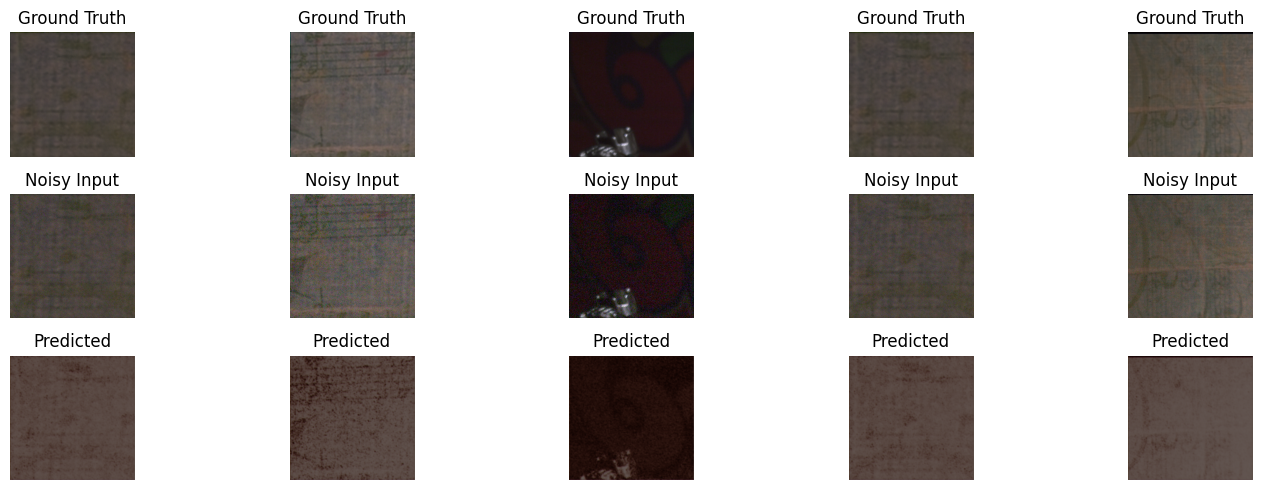

In [31]:
# Step 7: Visualize some of the prediction images (test set)

num_visualize = 5  # Number of images to visualize

fig, axs = plt.subplots(3, num_visualize, figsize=(15, 5))

for i in range(num_visualize):
    # Original ground truth image
    axs[0, i].imshow(ground_images_test[i])
    axs[0, i].axis('off')
    axs[0, i].set_title("Ground Truth")

    # Noisy input image
    axs[1, i].imshow(noisy_images_test[i])
    axs[1, i].axis('off')
    axs[1, i].set_title("Noisy Input")

    # Predicted image
    axs[2, i].imshow(test_predictions[i])
    axs[2, i].axis('off')
    axs[2, i].set_title("Predicted")

plt.tight_layout()
plt.show()

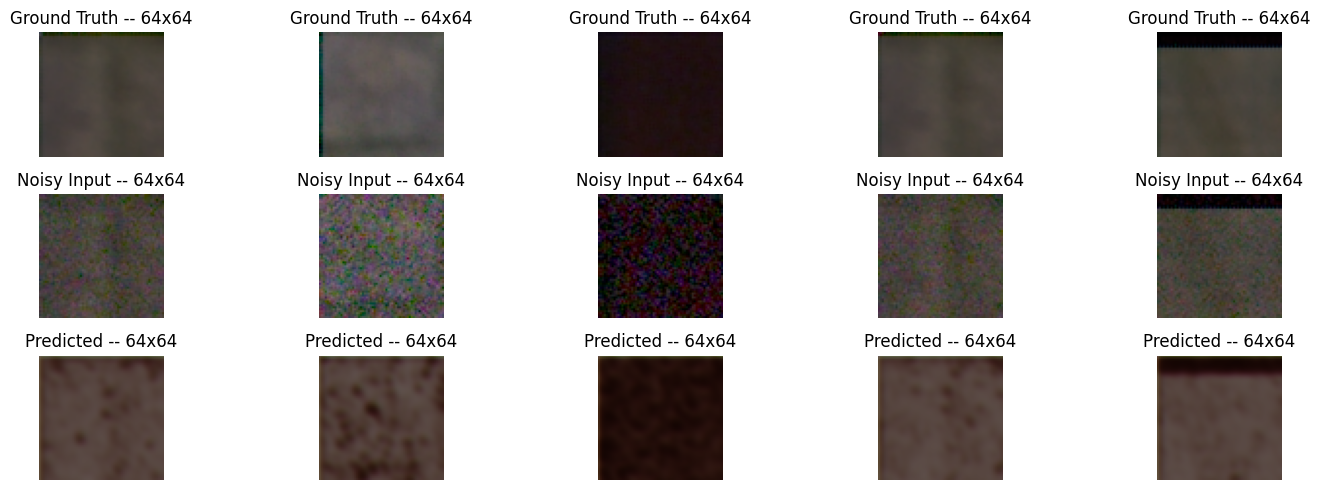

In [27]:
# Step 8: Visualize the prediction images in a 64x64 crop (test set)

num_visualize = 5  # Number of images to visualize

fig, axs = plt.subplots(3, num_visualize, figsize=(15, 5))

for i in range(num_visualize):
    # Original ground truth image
    axs[0, i].imshow(ground_images_test[i][0:64, 0:64, :])
    axs[0, i].axis('off')
    axs[0, i].set_title("Ground Truth -- 64x64")

    # Noisy input image
    axs[1, i].imshow(noisy_images_test[i][0:64, 0:64, :])
    axs[1, i].axis('off')
    axs[1, i].set_title("Noisy Input -- 64x64")

    # Predicted image
    axs[2, i].imshow(test_predictions[i][0:64, 0:64, :])
    axs[2, i].axis('off')
    axs[2, i].set_title("Predicted -- 64x64")

plt.tight_layout()
plt.show()